<a href="https://colab.research.google.com/github/omarrajaa/AI-4-Climate-Change-Identifying-plants-disease/blob/main/AI_4_Climate_Change_(Identifying_plants_disease).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying plants disease project 

first we need to import libraries  and put random state

In [128]:
#libraties
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
import os
#random state
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [131]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset
!unzip corn-or-maize-leaf-disease-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
corn-or-maize-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  corn-or-maize-leaf-disease-dataset.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Blight/Corn_Blight (101).jpg  
  inflating: data/Blight/Cor

In [138]:
def read_dataset(path):  # e.g. path = cats_and_dogs_filtered/train
    x = []  # images
    y = []  # labels

    # we will use os.listdir to read the contents of the folder
    labels = os.listdir(path)  # e.g. labels = ["cats", "dogs"]

    # iterate over the labels
    for label in labels:
        # we join the label to the path to get the path to the class folder which contains the images
        label_dir = os.path.join(path, label)  # e.g. cats_and_dogs_filtered/train/cat

        # we will use os.listdir again to read the contents of the class folders (i.e., the images)
        images = os.listdir(label_dir)  # e.g. ["cat.100.jpg", "cat.101.jpg", ...]

        # iterate over the images
        for image in os.listdir(label_dir):
            # we join the image name to the path to get the path to the image
            image_path = os.path.join(
                label_dir, image
            )  # e.g. cats_and_dogs_filtered/train/cats/cat.100.jpg

            # append the image path and the label to the lists
            x.append(image_path)
            y.append(label)

    # return a dataframe with the image paths and labels
    return pd.DataFrame({"image": x, "label": y})


# read the training and validation sets
train_df = read_dataset("data")

## processing data (pipelines)

In [139]:
label_to_index = {
    'Blight': 0,
    'Common_Rust': 1,
    'Gray_Leaf_Spot': 2,
    'Healthy': 3,
}

def image_to_resnet_tensor(x, y):
    # read the image from the path
    img = tf.io.read_file(x)
    # decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image
    img = tf.image.resize(img, [224, 224])
    # normalize the image
    img = img/225.0
    return img, y

def label_to_one_hot(x, y):
  y = tf.one_hot(y, depth=4)
  return x, y


def image_augmentation(x, y):
    # randomly flip the image horizontally
    img = tf.image.random_flip_left_right(x)
    # randomly flip the image vertically
    img = tf.image.random_flip_up_down(img)
    # randomly change the brightness of the image
    img = tf.image.random_brightness(img, max_delta=0.2)
    # clip the image to be between 0 and 1
    img = tf.clip_by_value(img, 0, 1)
    return img, y

train_df["label"] = train_df["label"].map(label_to_index)

In [140]:
def tf_dataset_creator(x, y, training=False):
    # create a tf.data.Dataset from the input output pairs
    dataset = tf.data.Dataset.from_tensor_slices((train_df["image"], train_df["label"]))
    # map the image paths to tensors using the new resnet preprocessing function
    dataset = dataset.map(image_to_resnet_tensor)
    # map the labels to one-hot encoded vectors
    dataset = dataset.map(label_to_one_hot)
    # if training, apply image augmentation. Remember that we never apply image augmentation to the validation set
    if training:
        dataset = dataset.map(image_augmentation)
    # shuffle the dataset
    dataset = dataset.shuffle(1000)
    # batch the dataset
    dataset = dataset.batch(32)
    return dataset

train_dataset = tf_dataset_creator(train_df["image"], train_df["label"], training=True)

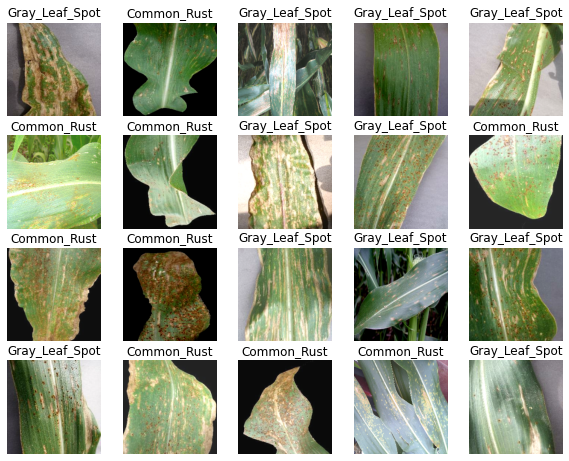

In [146]:
index_to_label = {
    0: 'Bilght',
    1: 'Common_Rust',
    2: 'Gray_Leaf_Spot',
    3: 'Healthy',
}

for image, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image[i].numpy())
        plt.title(index_to_label[np.argmax(label[i].numpy())])
        plt.axis("off")